# Evaluation of cross-training for classification tasks

The aim is to test how well a model, when trained on one dataset, performs on the other.

The idea is to consider the situation where you have labels for one context, but not for the other. So you must train your model your "source context" and hope it generalizes well to your "target context", where you have no labels!

The data is `sentiment/yelp.csv` (online restaurant reviews from Yelp) and `sentiment/movies.csv` (online movie reviews from IMDB). Both have a column called `text` with the text of the review and a column called `positive` which should be your outcome. No other variables are needed.

To do this:

1. Perform the "fitting" of both the vectorizer and the model on one of the sets
2. Use the "transform" of the vectorizer to transform the second dataset into the same feature space (X) that your model was trained on. 
3. Use the "predict" of the model to see how well it did on the second dataset. 

How well does your model generalize from one to the other? What does this say about "sentiment"?

This notebook is divided into 2 sections:

1.  Evaluate X-training performance 
2.  Improve X-training performance

# Install packages

In [2]:
# Install packages
import seaborn as sns
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.snowball import SnowballStemmer
import re
stemmer = SnowballStemmer("english")
not_alphanumeric_or_space = re.compile('[^(\w|\s|\d)]')
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
set(stopwords.words('english'))
stop_words = stopwords.words('english')

# Load files

In [9]:
# Load files
yelps = pd.read_csv('sentiment/yelps.csv')
yelps = yelps.sample(frac=0.1)
movies = pd.read_csv('sentiment/movies.csv')
movies = movies.sample(frac=0.01)

# Define functions

In [5]:
def preprocess_1(doc,  stop_words= stop_words):  
'''# Remove alphanumeric characters, decapitalise, lemmatise and remove stop words'''
        doc = doc.replace('-', ' ')
        doc = re.sub(not_alphanumeric_or_space, '', doc).lower() 
        words = [stemmer.stem(word) for word in doc.split() if word not in stop_words]
        return(' '.join(words).lower())

# def preprocess_2(doc,  movie_word_list = movie_word_list, stop_words= stop_words):   
# ''' Removes words that are not also present in movies'''
#         doc = doc.replace('-', ' ')
#         doc = re.sub(not_alphanumeric_or_space, '', doc).lower() 
#         words = [stemmer.stem(word) for word in doc.split() if word not in stop_words]
#         words = [word for word in words if word in movie_word_list]
#         return(' '.join(words).lower())

def get_scores(test_X, test_Y, train_X, train_Y):
'''Fit, predict and get scores'''
    fitted_models = [model.fit(train_X, train_Y) for name, model in models]
    pred_Ys = {str(name) + str(nom) : model.predict(df)
               for name, model in models for nom, df in [['test', test_X],['train', train_X]]}
    acc_scores = {str(name): accuracy_score(test_Y, predY)
                  for name, predY in pred_Ys.items() if name in ['NBtest', 'LRtest']} 
    acc_scores['LRtrain'] = accuracy_score(train_Y, pred_Ys['LRtrain']) 
    acc_scores['NBtrain'] = accuracy_score(train_Y, pred_Ys['NBtrain']) 
    
    return acc_scores

def get_movie_wordlist(movies, stop_words= stop_words):     
    movie_wordlist = []
    for movie in movies.text:
        movie = movie.replace('-', ' ')
        movie = re.sub(not_alphanumeric_or_space, '', movie).lower() 
        words = [stemmer.stem(word) for word in movie.split() if word not in stop_words]
        for word in words:
            if word not in movie_wordlist: movie_wordlist.append(word) 

    return movie_wordlist

# 1) Evaluate X-training performance

In [11]:
[i for i in yelps.text]

["David Tinter does a great job recomending the best suits based on my build and personality and overall service.  The Balani suits I have purchase have been great and I'm really happy with the look, fit and quality. Meetings with him are a breeze and turn around time is a lot faster than the companies I have used in the past. David comes right out to your office and does a preofessional job! Highly recommend!!",
 "This buffet is so underrated in my opinion. Someone in our group recommended this place and I was super surprised at how good it was! I've been to almost every buffet in vegas like wicked spoon at cosmo, bacchanal at ceasars, the buffet at the wynn, etc...and this one was as good if not better than the others! (yes I'm a fatty and proud of it).\n\nService: Doesn't really matter at a buffet because you serve yourself. In my opinion, my service was excellent, so no complaints. Got up and got food real quick. BUT if you want to be nitpicky, it did take a little while to get sea

[Text(0.5, 1.0, 'Accuracy scores')]

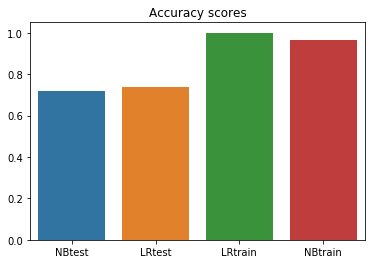

In [10]:
# Vectorise yelps and movies
vectorizer = TfidfVectorizer(use_idf = False, # Use counts not idfs
                             norm= False, # We want actual counts not adjusted numbers
                             preprocessor = preprocess_1, # Neat way of passing my preprocessor - note that stop words are removed here not later!
                             min_df = 10, # Min occurrences of word across all docs
                             max_df = 10000) # Max occurrences across all docs

# Define test and train sets
yX = vectorizer.fit_transform([i for i in yelps.text]).todense()
mX = vectorizer.transform([i for i in movies.text]).todense()
yY = [i for i in yelps.positive]
mY = [i for i in movies.positive]

# Fit, predict and get scores
models = [('NB', MultinomialNB(fit_prior=False)),
          ('LR', LogisticRegression(solver='lbfgs', multi_class='auto'))]

scores = get_scores(yX, yY, mX, mY)

sns.barplot(list(scores.keys()), list(scores.values())).set(title = 'Accuracy scores')

In [95]:
scores

{'NBtest': 0.6790096297111087,
 'LRtest': 0.7704968850934472,
 'LRtrain': 0.9392036477811331,
 'NBtrain': 0.8537087774733516}

## Comments

- We see here that our model applies poorly to the new context, especially for naive Bayes. The accuracy scores are much lower for our test data compared to the train data.
- In other words, the model does not generalise well. It seems that sentiment is rather specific to the context.

# 2) Try to improve X-training performance

Try to improve your transfer score using the unlabelled target data, P(X). What could we learn from the target context (without using the labels, only from the X) that might help you when training your model on your source context? How can you construct a feature space in your source context that generalizes better? 

In [96]:
movie_word_list = get_movie_wordlist(movies)

In [1]:
# Vectorise yelps and movies
vectorizer = TfidfVectorizer(use_idf = False, # Use counts not idfs
                             norm= False, # We want actual counts not adjusted numbers
                             preprocessor = preprocess_2, # Neat way of passing my preprocessor - note that stop words are removed here not later!
                             min_df = 10, # Min occurrences of word across all docs
                             max_df = 10000) # Max occurrences across all docs

# Define test and train sets
yX = vectorizer.fit_transform([i for i in yelps.text]).todense()
mX = vectorizer.transform([i for i in movies.text]).todense()
yY = [i for i in yelps.positive]
mY = [i for i in movies.positive]

scores_2 = get_scores(yX, yY, mX, mY)

[Text(0.5, 1.0, 'Accuracy scores with improved methodology')]

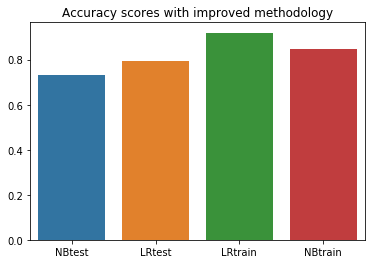

In [98]:
sns.barplot(list(scores_2.keys()), list(scores_2.values())).set(title = 'Accuracy scores with improved methodology')

In [99]:
scores_2

{'NBtest': 0.7308380748577543,
 'LRtest': 0.7927662170134896,
 'LRtrain': 0.9195048297102174,
 'NBtrain': 0.8469891806491611}

## Comments

- In the second example I restricted our feature list to those words which occur in both corpuses.
- This has resulted in a small improvement; with additional time I would play with the maximum and minimum times that a word must occur in both corpuses to further improve the results!